In [1]:
import sys
import os
import numpy as np
import h5py
import scipy.io
import tensorflow as tf
from keras import ops
import keras

#import tensorflow.keras as keras
from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import concatenate
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import math

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, average_precision_score
import sys
sys.path.append("/hpcnfs/data/GN2/gmandana/take2project/clip_2_electric_boogaloo/analysis/NN/Neural_Network_DNA_Demo")
sys.path.append("/hpcnfs/data/GN2/gmandana/bin/DeepRiPe_edited/Scripts/")
from helper import IOHelper, SequenceHelper

import random
rs = 1234
random.seed(rs)

2024-05-14 09:30:44.188695: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 09:30:44.193250: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 09:30:44.250214: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 09:30:46.389891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

def create_model1(num_task = 1,input_len_l = 500):
	K.clear_session()
	left_dim=4
	right_dim=4
	num_units=50
	input_l=input_len_l

	nb_f_l=[90,100]
	f_len_l=[7,7]
	p_len_l=[4,10]
	s_l=[2,5]
	nb_f_r=[90,100]
	f_len_r=[7,7]
	p_len_r=[10,10]
	s_r=[5,5]

	left_input = Input(shape=(input_l,left_dim),name="left_input")

	left_conv1 = Conv1D(filters=nb_f_l[0],kernel_size=f_len_l[0], padding='valid',activation="relu",name="left_conv1")(left_input)
	left_pool1 = MaxPooling1D(pool_size=p_len_l[0], strides=s_l[0],name="left_pool1")(left_conv1)
	left_drop1 = Dropout(0.25,name="left_drop1")(left_pool1)

	conv_merged = Conv1D(filters=100,kernel_size= 5, padding='valid',activation="relu",name="conv_merged")(left_drop1)
	merged_pool = MaxPooling1D(pool_size=10, strides=5)(conv_merged)
	merged_drop = Dropout(0.25)(merged_pool)
	merged_flat = Flatten()(merged_drop)

	hidden1 = Dense(250, activation='relu',name="hidden1")(merged_flat)
	output = Dense(num_task, activation='sigmoid',name="output")(hidden1)
	model = Model(inputs=left_input, outputs=output)
	print(model.summary())
	return model

def create_class_weight(labels_dict,total,mu=0.15):
    keys = labels_dict.keys()
    class_weight = dict()
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

@keras.saving.register_keras_serializable(package="my_package", name="myprecision")
def myprecision(y_true, y_pred):
	true_positives = tf.math.reduce_sum(tf.math.round(tf.keras.ops.clip(y_true * y_pred, 0, 1)))
	predicted_positives = tf.math.reduce_sum(tf.math.round(tf.keras.ops.clip(y_pred, 0, 1)))
	precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
	return precision

@keras.saving.register_keras_serializable(package="my_package", name="myrecall")
def myrecall(y_true, y_pred):
	true_positives = tf.math.reduce_sum(tf.math.round(tf.keras.ops.clip(y_true * y_pred, 0, 1)))
	possible_positives = tf.math.reduce_sum(tf.math.round(tf.keras.ops.clip(y_true, 0, 1)))
	recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
	return recall

In [3]:
model_path = "/hpcnfs/data/GN2/gmandana/bin/restr_NN/"
fg_fasta_data = IOHelper.get_fastas_from_file("/hpcnfs/data/GN2/gmandana/bin/4.1.0/home/ieo5559/unifiedCLIP/NN_files/siW/fg.fa", uppercase=True)
bg_fasta_data = IOHelper.get_fastas_from_file("/hpcnfs/data/GN2/gmandana/bin/4.1.0/home/ieo5559/unifiedCLIP/NN_files/siW/bg.fa", uppercase=True)

sequence_length = len(fg_fasta_data.sequence[0])

fg_seq_matrix = SequenceHelper.do_one_hot_encoding(fg_fasta_data.sequence, sequence_length, SequenceHelper.parse_alpha_to_seq)
bg_seq_matrix = SequenceHelper.do_one_hot_encoding(bg_fasta_data.sequence, sequence_length, SequenceHelper.parse_alpha_to_seq)

seq_matrix = np.concatenate((fg_seq_matrix,bg_seq_matrix))
Y = np.hstack([np.ones((np.shape(fg_seq_matrix)[0], )), np.zeros((np.shape(bg_seq_matrix)[0], ))])
X_train, X_test, y_train , y_test = train_test_split(seq_matrix, Y, test_size = 0.3, random_state = rs)

In [4]:
model=load_model(os.path.join(model_path, "siW_NN_v1" + ".keras"), custom_objects={"custom_fn": myprecision, "custom_fn": myrecall})

In [190]:
from igrads import igrads
from igrads import integrated_gradients
from igrads import plot_sequence_attribution
np.set_printoptions(suppress=True)

In [218]:
print(y_train[1005:1015])
model.predict(X_train[1005:1015].reshape(10,500,4))

[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.00549658],
       [0.0307618 ],
       [0.9878187 ],
       [0.9670527 ],
       [0.8505529 ],
       [0.00000528],
       [0.00560766],
       [0.00008617],
       [0.14040881],
       [0.01622995]], dtype=float32)

In [222]:
#baseline = tf.zeros(tf.shape(X_train[0]))
baseline = np.full((500,4), 0.0)
#baseline = X_train[33]

attriutions = integrated_gradients(X_train[1008], baseline, model)

In [115]:
### 
#print(model.predict(X_train[0].reshape(1,500,4)))
print(model.predict(np.zeros((1,500,4))))
#print(model.predict(X_train[33].reshape(1,500,4)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.9759222]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.45854068]]


findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.


findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Ro

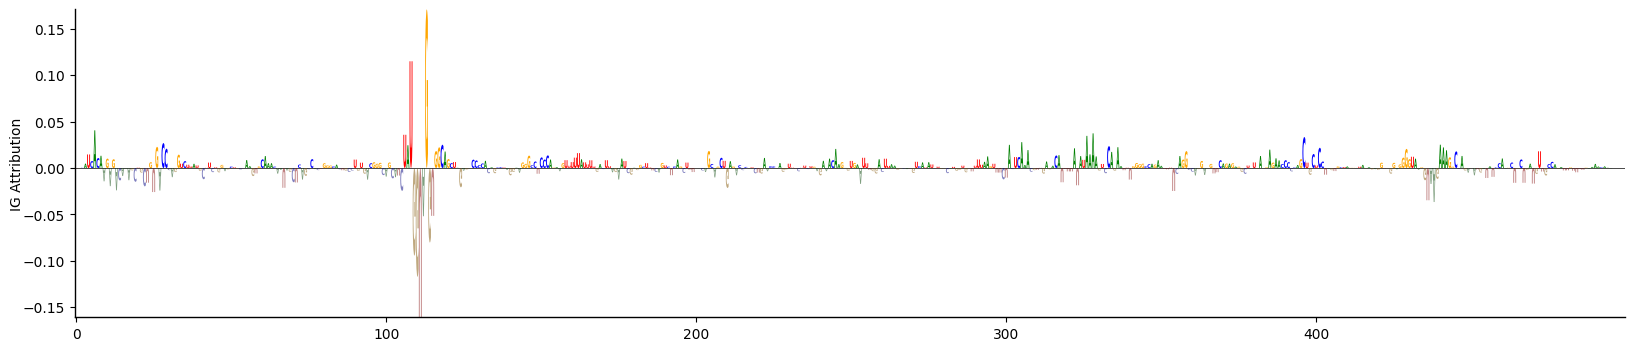

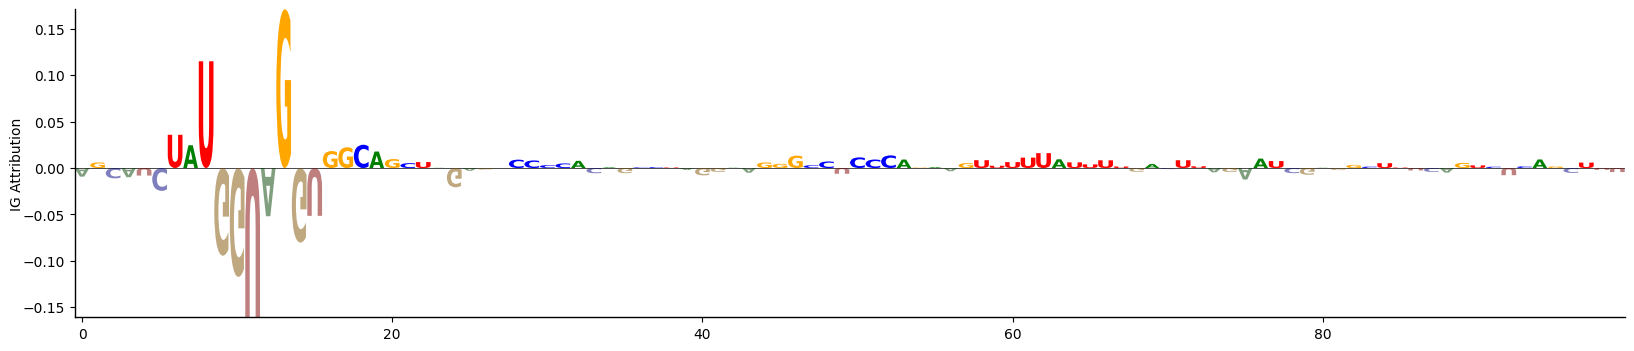

In [224]:
%matplotlib inline
plot_sequence_attribution(attriutions.numpy()[0:500,:], sigma=['A', 'C', 'U', 'G'])
plot_sequence_attribution(attriutions.numpy()[100:200,:], sigma=['A', 'C', 'U', 'G'])

In [211]:
np.sum(attriutions.numpy())

0.5409817

In [138]:
def computegradients(inputs, model):
    with tf.GradientTape(persistent=True) as tape:
        # watch gradients of inputs
        tape.watch(inputs)
        
        # run model predictions on inputs
        pred = model(inputs)

        # reduce_sum for each batch
        pred_sum = tf.reduce_sum(pred, axis=tf.range(1, tf.rank(pred)))

    return tape.gradient(pred_sum, inputs)

def interpolate(x, baseline, steps=50):
    alphas = tf.linspace(start=0.0, stop=1.0, num=steps+1)
    delta = x - baseline
    return tf.vectorized_map(lambda a: baseline + delta * a, alphas)

def nestedinterpolate(x, baseline, steps=50):
    x_flattened = tf.nest.flatten(x)
    baseline_flattened = tf.nest.flatten(baseline)
    interpolated_flattened = [interpolate(x, baseline, steps) for x, baseline in zip(x_flattened, baseline_flattened)]
    return tf.nest.pack_sequence_as(x, interpolated_flattened)

In [212]:
#baseline = X_train[4]
## a 50x500x4 matrix, i.e., for each interpolated sequence, the partial derivative of the function w.r.t each nucleotide position
computegradients(nestedinterpolate(X_train[0], baseline, 50), model)[0]

<tf.Tensor: shape=(500, 4), dtype=float32, numpy=
array([[-0.00841923,  0.0056836 ,  0.00842653, -0.05986665],
       [ 0.01926542, -0.0325581 ,  0.00476327, -0.03587785],
       [ 0.00171162, -0.03243666,  0.00381544,  0.00062156],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)>

In [213]:
## for each interpolated sequence, calculate the integral, return mean over all 50 interpolated sequences
integ_approx = igrads._integral_approximation(computegradients(nestedinterpolate(X_train[0], baseline, 50), model))
integ_approx

<tf.Tensor: shape=(500, 4), dtype=float32, numpy=
array([[-0.0002077 , -0.00025655,  0.00013402, -0.0003134 ],
       [ 0.00018061, -0.00036734, -0.00011402, -0.00033367],
       [-0.00043703,  0.00039533,  0.00027555, -0.00227815],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)>

In [214]:
d = igrads.apply_fn_elementwise_structures(lambda x, y: x-y, X_train[0], baseline)
igrads.apply_fn_elementwise_structures(lambda x, y: x*y, d, integ_approx)

<tf.Tensor: shape=(500, 4), dtype=float32, numpy=
array([[-0.        , -0.        ,  0.        , -0.0003134 ],
       [ 0.        , -0.00036734, -0.        , -0.        ],
       [-0.        ,  0.        ,  0.00027555, -0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)>